# Gaussian fitting loop for S I Lines
With the new and revised version on fitting the COS data, we can create a loop that will semi-automatically return the parameters and brightness for the given wavelength.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import matplotlib.ticker as ticker
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
line = 1250.8140
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

In [9]:
df_results = pd.DataFrame()
problem_files = {}

In [10]:
wavelength_list = df_wavelength.values.tolist()

In [11]:
def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((wl_array-cen1)/sigma1)**2)))

 50%|██████████████████████████████████████████                                          | 1/2 [00:03<00:03,  3.51s/it]

The brightness of S I at 1208.85 Angstrom is 1.9556900906096852e-16.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.47s/it]

The brightness of S I at 1211.212 Angstrom is 4.3122092013211987e-16.


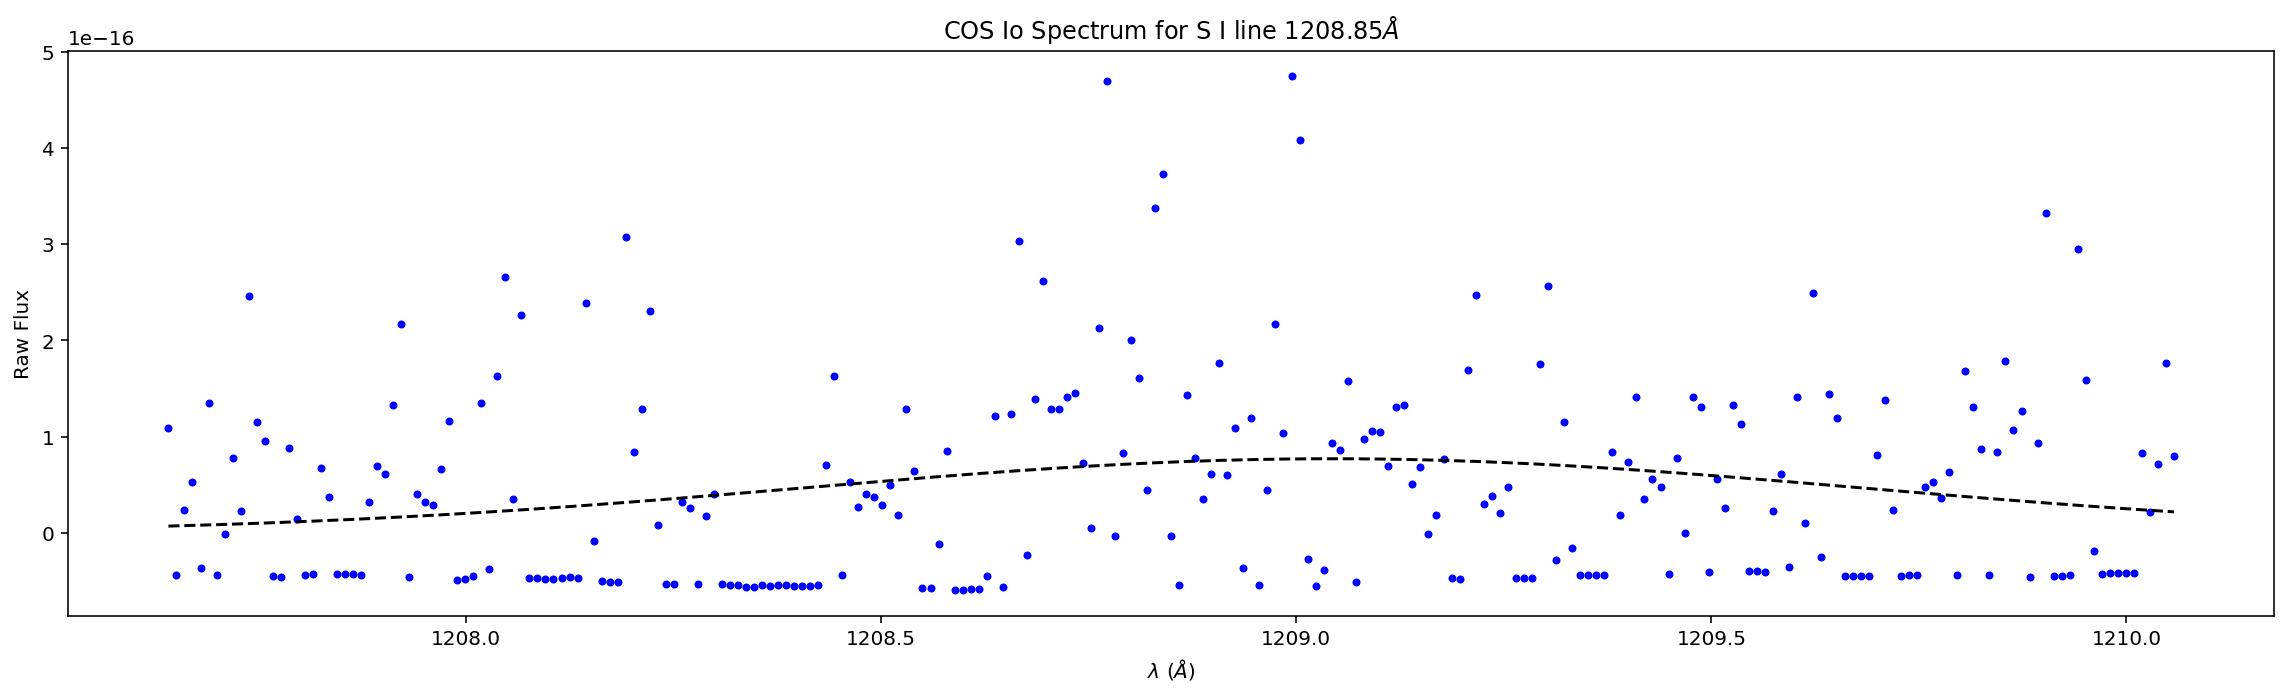

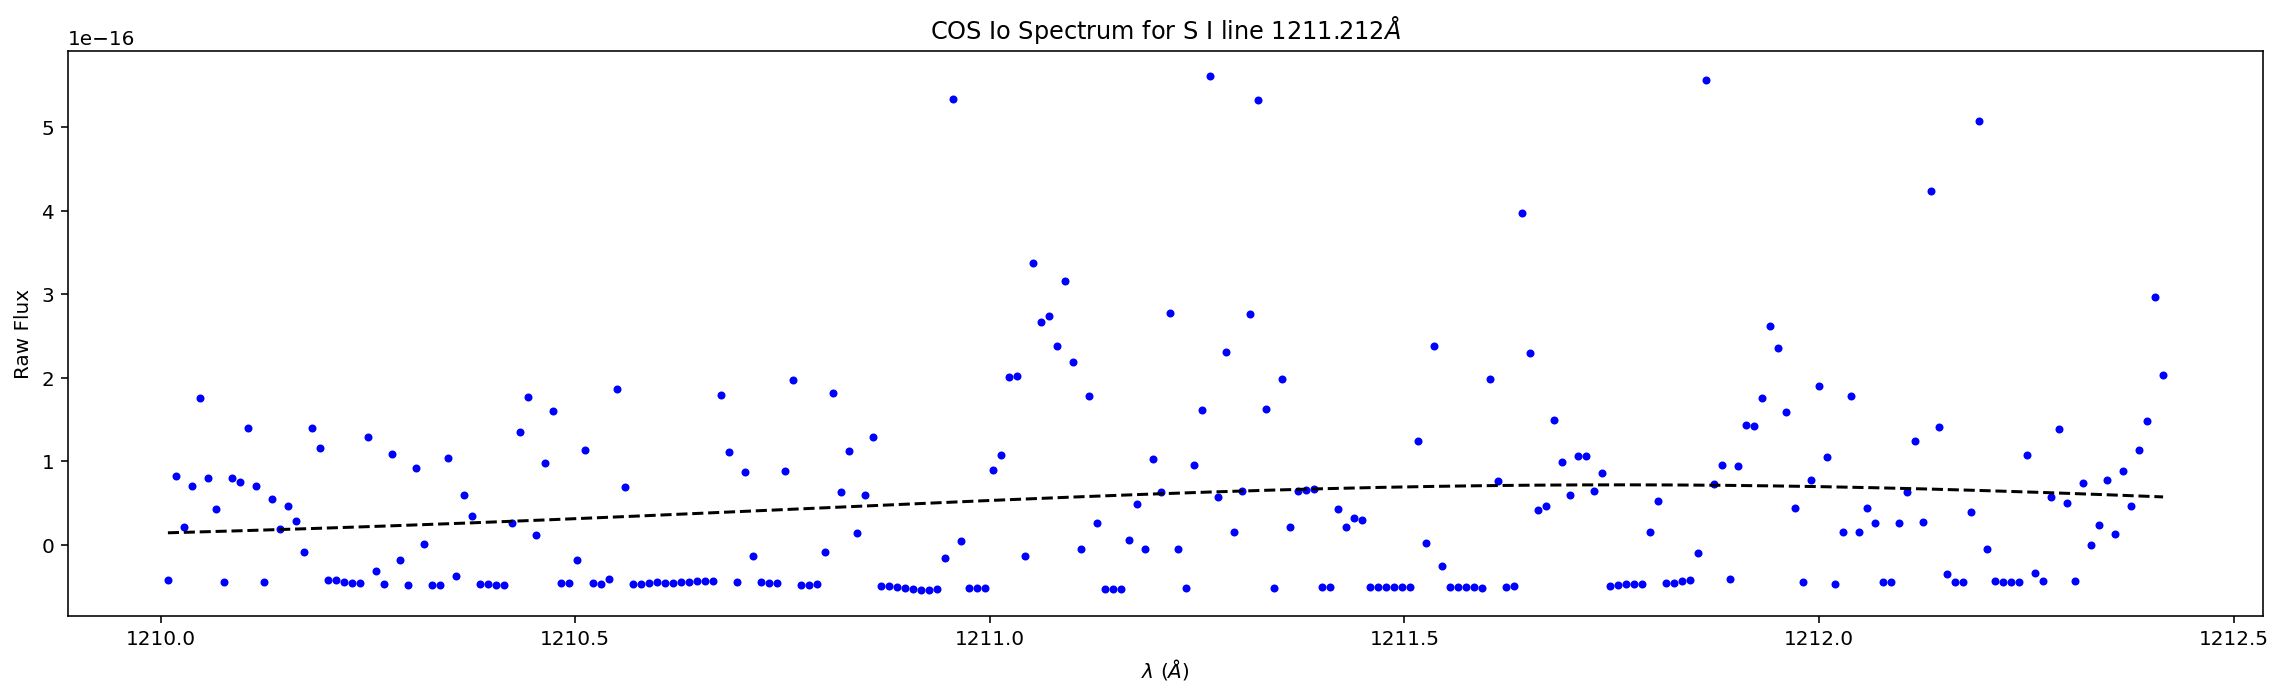

In [12]:
for index in tqdm(range(0, 2)):
    #len(wavelength_list) for whole list
    
    line = wavelength_list[index]
    try:
        left_bound = 0.999*line
        right_bound = 1.001*line

        sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
        wl = evt_data['WAVELENGTH'][sub_region]
        flux = evt_data['FLUX'][sub_region]
        unc = 0.1*flux #placeholder uncertainty
        wl_array = wl.data
        flux_array = flux.data

        amp1 = 1*10**-14
        sigma1 = 1
        cen1 = line

        popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, wl_array, flux_array, p0=[amp1, cen1, sigma1])

        perr_gauss = np.sqrt(np.diag(pcov_gauss))

        a = popt_gauss[0]
        a_err = perr_gauss[0]
        mu = popt_gauss[1]
        mu_err = perr_gauss[1]
        w = popt_gauss[2]
        w_err = perr_gauss[2]

        plt.figure(figsize=(16, 5))
        plt.plot(wl_array,flux_array,'b.') #make it columns instead of rows bc otherwise will be a blank plot
        plt.plot(wl_array, _1gaussian(wl_array, *popt_gauss), 'k--')
        plt.xlabel('$\lambda$ ($\AA$)');
        plt.ylabel('Raw Flux')
        plt.title("COS Io Spectrum for S I line {}$\AA$".format(line))
        plt.tight_layout()
        save_place = '/Users/jojoa/GitHub/io_brightness/data/figures/single_fit/'
        plt.savefig(save_place+"gauss_fit_{}.jpg".format(line), format="jpg",dpi=1000)

        brightness = ((2*np.pi)**.5)*(a*w)
        #print("The brightness of S I at {} Angstrom is {}.".format(line,brightness))

        gauss_width = w
        gauss_width_unc = w_err
        obs_line_center = mu
        obs_line_center_unc = mu_err
        gauss_amp = a
        gauss_amp_unc = a_err

        temp = {'int_wv':line, 'obs_line_center':obs_line_center, 'obs_line_center_unc':obs_line_center_unc, 
                'gaussian_width':gauss_width, 'gaussian_width_unc':gauss_width_unc, 'gauss_amp':gauss_amp, 
                'gauss_amp_unc':gauss_amp_unc, 'brightness':brightness}

        df_results = df_results.append(temp, ignore_index=True)
        if (index % 10) == 0:
                    #print(index, fn[-49:])
                    df_results.to_csv('../data/single_gauss_fit/io_results_june_8.csv',index=False)
                    
    except:
        print("Fail:", line)
        problem_files[index] = line
        prob_data = list(problem_files.items())
        problem_array = np.array(prob_data)

Now that we have run the loop, let us save the file for later use.

In [ ]:
prob_data = list(problem_files.items())
problem_array = np.array(prob_data)
problem_array